# ECG-Classification-Q
#### @based-on https://github.com/SEU-wzx/ECGAI_1D-CNN

## Import Packages

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import random
import numpy as np
import scipy.io as scio
import pandas as pd
import os
import collections
from matplotlib import pyplot as plt

from keras import optimizers
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv1D, BatchNormalization, MaxPooling1D
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

## Set Path

In [2]:
base_path = './'
dataset_path =  './Dataset' # Training data

## Plot Settings

In [3]:
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

## Data Process

In [4]:
# Variables

classes = ['NSR', 'APB', 'AFL', 'AFIB', 'SVTA', 'WPW','PVC', 'Bigeminy', 'Trigeminy', 
           'VT', 'IVR', 'VFL', 'Fusion', 'LBBBB', 'RBBBB', 'SDHB', 'PR']
ClassesNum = len(classes)

X = list()
y = list()

for root, dirs, files in os.walk(dataset_path, topdown=False):
    for name in files:
        data_train = scio.loadmat(os.path.join(root, name))# 取出字典里的value
        
        # arr -> list
        data_arr = data_train.get('val')
        data_list = data_arr.tolist()
        
        X.append(data_list[0]) # [[……]] -> [ ]
        y.append(int(os.path.basename(root)[0:2]) - 1)  # name -> num

## Layers

In [5]:
def nn_base(Unit, Kernel, Conv_Stride, Maxpool_Stride, input_tensor = None):
    
    input_shape = (None, 3)

    ecg_input = input_tensor

    bn_axis = 3

    # nn_base
    x = Conv1D(filters = Unit, kernel_size = Kernel, padding = 'same', strides = Conv_Stride, activation = 'relu', 
               data_format='channels_last')(ecg_input)
    
    x = BatchNormalization()(x)
    
    x = MaxPooling1D(pool_size = 2, strides = Maxpool_Stride, padding = 'same', 
                     data_format='channels_last')(x)

    return x

In [6]:
def classifier_layer(base_layer, dropout_rate = 0.1, ClassesNum = 17):
    
    # classifier layers
    x = Conv1D(filters = 32, kernel_size = 10, padding = 'same', activation = 'relu', 
               name = 'classifier_layer_Conv1D1', data_format='channels_last')(base_layer)
    
    x = Conv1D(filters = 128, kernel_size = 5, padding = 'same', activation = 'relu', 
               strides = 2, name = 'classifier_layer_Conv1D2', data_format='channels_last')(x)
    
    x = MaxPooling1D(pool_size = 2, strides = 2, padding = 'same', 
                     name = 'classifier_layer_MaxPooling1D1', data_format='channels_last')(x)
    
    x = Conv1D(filters = 256, kernel_size = 15, padding = 'same', activation = 'relu', 
               name = 'classifier_layer_Conv1D3', data_format='channels_last')(x)
    
    x = MaxPooling1D(pool_size = 2, strides = 2, padding = 'same', 
                     name = 'classifier_layer_MaxPooling1D2', data_format='channels_last')(x)
    
    x = Conv1D(filters = 512, kernel_size = 5, padding = 'same', activation = 'relu', 
               name = 'classifier_layer_Conv1D4', data_format='channels_last')(x)
    
    x = Conv1D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu', 
               name = 'classifier_layer_Conv1D5', data_format='channels_last')(x)
    
    
    x = Flatten(name = 'classifier_layer_Flatten')(x)
    x = Dense(units = 512, activation = 'relu', name = 'classifier_layer_Dense1')(x)
    x = Dropout(rate = dropout_rate, name = 'classifier_layer_Dropout')(x)
    x = Dense(units = ClassesNum, activation = 'softmax', name = 'classifier_layer_Dense2')(x)
    
    return x

## Dataset Check

In [7]:
# list -> arr
X=np.array(X)
y=np.array(y)

print("total num of training data : ", len(X))

# get X_train, X_test, y_train, y_test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("X_train : ", len(X_train))
print("X_test  : ", len(X_test))
print("y_train : ", collections.Counter(y_train))
print("y_test  : ", collections.Counter(y_test))
print("shape of X_train : ", np.shape(X_train[0]))
print("shape of y_train : ", np.shape(y_train))
print("shape of X_test : ", np.shape(X_test))
print("shape of y_test : ", np.shape(y_test))

total num of training data :  1000
X_train :  800
X_test  :  200
y_train :  Counter({0: 223, 3: 109, 6: 104, 13: 85, 1: 54, 14: 51, 7: 39, 16: 35, 5: 17, 2: 15, 4: 11, 12: 10, 11: 10, 8: 10, 15: 10, 10: 9, 9: 8})
y_test  :  Counter({0: 60, 6: 29, 3: 26, 13: 18, 7: 16, 1: 12, 14: 11, 16: 10, 2: 5, 5: 4, 8: 3, 4: 2, 9: 2, 12: 1, 10: 1})
shape of X_train :  (3600,)
shape of y_train :  (800,)
shape of X_test :  (200, 3600)
shape of y_test :  (200,)


## Model Graph

In [8]:
input_ecg = Input(shape=(3600,1))
x = nn_base(128, 50, Conv_Stride = 3, Maxpool_Stride = 3, input_tensor = input_ecg)
x = nn_base(32, 7, Conv_Stride = 1, Maxpool_Stride = 2, input_tensor = x)
output_ecg = classifier_layer(x, dropout_rate = 0.1, ClassesNum = 17)
model_m = Model(input_ecg, output_ecg)
print(model_m.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3600, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1200, 128)         6528      
_________________________________________________________________
batch_normalization (BatchNo (None, 1200, 128)         512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 400, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 400, 32)           28704     
_________________________________________________________________
batch_normalization_1 (Batch (None, 400, 32)           128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 200, 32)           0     

## Settings optimizers & compile

In [9]:
# setting optimizers & compile
optimizers.Adam(lr = 0.002, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
# model_all.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_m.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# expand X_train dims
X_train = np.expand_dims(X_train, axis=2)
X_test = np.reshape(X_test, (np.shape(X_test)[0], np.shape(X_test)[1], 1))
# Y : int -> binary (one-hot)
y_train = to_categorical(y_train,num_classes = ClassesNum)
y_test = to_categorical(y_test,num_classes = ClassesNum)

display(np.shape(X_train))

(800, 3600, 1)

## Train

In [10]:
BATCH_SIZE = 16
EPOCHS = 50
# history = model_all.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS)
history = model_m.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS)

Epoch 1/50
50/50 [==============================] - 4s 61ms/step - loss: 2.6148 - accuracy: 0.2376
Epoch 2/50
50/50 [==============================] - 3s 65ms/step - loss: 2.1183 - accuracy: 0.3388
Epoch 3/50
50/50 [==============================] - 3s 61ms/step - loss: 1.8277 - accuracy: 0.4472
Epoch 4/50
50/50 [==============================] - 3s 60ms/step - loss: 1.4459 - accuracy: 0.5607
Epoch 5/50
50/50 [==============================] - 3s 62ms/step - loss: 1.3626 - accuracy: 0.5907
Epoch 6/50
50/50 [==============================] - 3s 61ms/step - loss: 0.8769 - accuracy: 0.7381
Epoch 7/50
50/50 [==============================] - 3s 61ms/step - loss: 0.5800 - accuracy: 0.8258
Epoch 8/50
50/50 [==============================] - 3s 60ms/step - loss: 0.4856 - accuracy: 0.8548
Epoch 9/50
50/50 [==============================] - 3s 63ms/step - loss: 0.5545 - accuracy: 0.8416
Epoch 10/50
50/50 [==============================] - 3s 63ms/step - loss: 0.3755 - accuracy: 0.8878
Epoch 11/

## Accuracy & Loss

In [11]:
print(history.history.keys())
print(history.history['loss'])
print(history.history['accuracy'])

dict_keys(['loss', 'accuracy'])
[2.448559045791626, 2.1282994747161865, 1.7727857828140259, 1.4726184606552124, 1.2851171493530273, 0.8230487704277039, 0.5826590657234192, 0.537813127040863, 0.5403570532798767, 0.46318191289901733, 0.41595545411109924, 0.23795126378536224, 0.22980327904224396, 0.1257442682981491, 0.07355410605669022, 0.13930743932724, 0.11463785171508789, 0.2593943476676941, 0.08485419303178787, 0.025699276477098465, 0.027964066714048386, 0.06855059415102005, 0.09428571909666061, 0.2435474842786789, 0.14356322586536407, 0.17830562591552734, 0.13003067672252655, 0.022915560752153397, 0.019050247967243195, 0.059116754680871964, 0.04505375027656555, 0.045350752770900726, 0.23409032821655273, 0.055844902992248535, 0.04123230278491974, 0.0438087098300457, 0.08746051788330078, 0.06435957551002502, 0.05527491867542267, 0.040797144174575806, 0.029848402366042137, 0.02172870934009552, 0.015833701938390732, 0.0017687092768028378, 0.0018687346018850803, 0.0009460797882638872, 0.0

## Plot

Text(0.5, 1.0, 'acc')

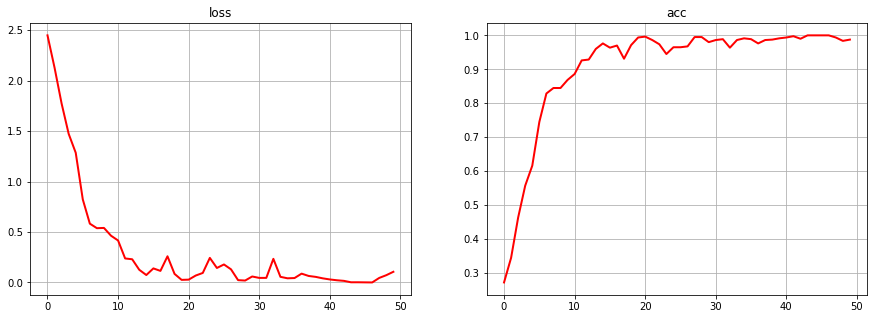

In [12]:

# put into df
record_arr = np.array([history.history['loss'][0], history.history['accuracy'][0]])
for i in range(1, EPOCHS):
    new_row = np.array([history.history['loss'][i], history.history['accuracy'][i]])
    record_arr = np.row_stack((record_arr, new_row))
    
record_df = pd.DataFrame(record_arr, columns=["loss", "acc"])

#print curve
plt.subplot(1,2,1)
plt.plot(np.arange(0, EPOCHS), record_df["loss"], 'r')
plt.title('loss')
plt.subplot(1,2,2)
plt.plot(np.arange(0, EPOCHS), record_df["acc"], 'r')
plt.title('acc')

In [13]:
# val_loss_acc = model_all.evaluate(X_test, y_test, batch_size=100)
val_loss_acc = model_m.evaluate(X_test, y_test, batch_size = 16)
print("loss of val : ", val_loss_acc[0])
print("acc of val : ", val_loss_acc[1])

13/13 [==============================] - 0s 10ms/step - loss: 1.8498 - accuracy: 0.5250
loss of val :  1.8497918844223022
acc of val :  0.5249999761581421


## Predict

In [14]:
# predictions = model_all.predict(X_test)
predictions = model_m.predict(X_test)
display(predictions)

array([[8.1491476e-01, 6.9638506e-02, 7.4795932e-03, ..., 2.4068212e-02,
        8.4783032e-04, 8.4022101e-04],
       [1.0645549e-02, 3.1387465e-04, 5.9893378e-04, ..., 1.3022801e-05,
        2.4205389e-04, 8.9657122e-01],
       [9.8920912e-01, 7.1114898e-03, 2.9202463e-04, ..., 2.0546225e-04,
        5.8265283e-07, 6.3757551e-07],
       ...,
       [3.6522271e-16, 6.8862347e-13, 1.4558334e-25, ..., 3.2264449e-19,
        1.2790442e-22, 4.8355242e-21],
       [7.6306576e-01, 6.4809479e-02, 4.0610399e-02, ..., 9.2622787e-03,
        1.4802314e-03, 8.7084144e-04],
       [6.6221011e-01, 9.8271547e-03, 1.4490127e-03, ..., 2.8111377e-01,
        2.0239773e-04, 3.5512864e-04]], dtype=float32)